взять любой набор данных для бинарной классификации (можно скачать один из модельных с 
1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать feature engineering
3. обучить любой классификатор (какой вам нравится)
4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
5. применить random negative sampling для построения классификатора в новых условиях
6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
7. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

**1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)**

Набор данных https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+#

Экспериментальные данные, используемые для бинарной классификации (заполняемость комнаты) по температуре, влажности, освещенности и CO2. Фактическая занятость была получена по фотографиям с отметкой времени, которые делались каждую минуту.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
df = pd.read_csv("datatraining.txt")
df.head(3)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1


5 столбцов для анализа, бинарная целевая переменная Occupancy.

Столбец date - метка времени. Для наших целей он не нужен, убираем.

In [3]:
df.shape

(8143, 7)

Всего 8143 наблюдения. 

In [4]:
df = df.drop(['date'], axis=1)

Посмотрим на соотношение классов

In [5]:
df.iloc[:, -1].value_counts()
# df.Occupancy.value_counts()

0    6414
1    1729
Name: Occupancy, dtype: int64

In [6]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


Из описания видно, что всё в порядке с Температурой и Влажностью

Проверить на выбросы Освещенность, СО2 и HumidityRatio

**2. сделать feature engineering**

<AxesSubplot:ylabel='Frequency'>

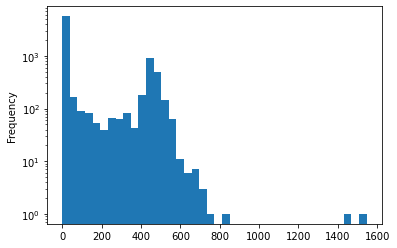

In [7]:
df.Light.plot.hist(log=True, bins=40)

Похоже есть выбросы по признаку Light - сделаем их равными медиане.

In [8]:
light_median = df.loc[df['Light'] < 1000, 'Light'].median()
df.loc[df['Light'] > 1000, 'Light'] = light_median

<AxesSubplot:ylabel='Frequency'>

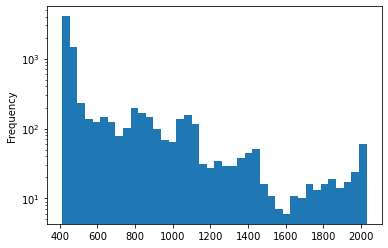

In [9]:
df.CO2.plot.hist(bins=40, log=True)

<AxesSubplot:ylabel='Frequency'>

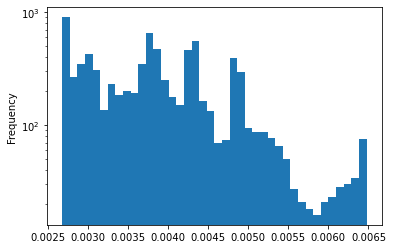

In [10]:
df.HumidityRatio.plot.hist(bins=40, log=True)

С СО2 и HumidityRatio все хорошо

Посмотрим корреляцию признаков с целевой переменной.

In [11]:
correlation = df.corr()
corr_with_target = correlation["Occupancy"].sort_values(ascending = False)
corr_with_target

Occupancy        1.000000
Light            0.913949
CO2              0.712235
Temperature      0.538220
HumidityRatio    0.300282
Humidity         0.132964
Name: Occupancy, dtype: float64

**3. обучить любой классификатор (какой вам нравится)**

Разбиваем выборку на тренировочную и тестовую части и обучаем модель (в примере - градиентный бустинг)

In [12]:
from sklearn.model_selection import train_test_split

x_data = df.iloc[:,:-1]
y_data = df.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

In [13]:
x_train

,Temperature,Humidity,Light,CO2,HumidityRatio
7422,20.5000,33.5900,0.0,678.50,0.005014
4584,19.7900,28.0000,0.0,438.00,0.003993
5697,19.5000,26.9450,24.0,422.00,0.003773
6537,19.2900,26.2000,0.0,465.00,0.003620
7677,20.2900,32.9500,0.0,465.00,0.004854
...,...,...,...,...,...
5700,19.5000,27.0000,24.0,421.75,0.003781
2551,21.7900,20.2950,489.0,801.50,0.003270
538,21.0500,24.8400,0.0,435.50,0.003828
1221,22.2225,25.8925,448.0,775.50,0.004290


In [14]:
import xgboost as xgb

model = xgb.XGBClassifier()

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

[14:55:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\gribanov\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Проверяем качество

In [15]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

def evaluate_results(y_test, y_predict):
#     print('Classification results:')
    f1 = f1_score(y_test, y_predict)
#     print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
#     print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
#     print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
#     print("precision: %.2f%%" % (prc * 100.0)) 
    return {
        'FScore': f1, 
        'Roc-Auc': roc,
        'Precision': prc, 
        'Recall': rec,
    }

    
without_pu = evaluate_results(y_test, y_predict)
without_pu

{'FScore': 0.9754838709677419,
 'Roc-Auc': 0.9843463281279256,
 'Precision': 0.9742268041237113,
 'Recall': 0.9767441860465116}

**4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть**

Представим, что нам неизвестны негативы и часть позитивов

In [16]:
# mod_data = df.copy()

# #get the indices of the positives samples
# pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]

# #shuffle them
# np.random.shuffle(pos_ind)

# # leave just 25% of the positives marked
# pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
# print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
# pos_sample = pos_ind[:pos_sample_len]

In [17]:
# mod_data

Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [18]:
# mod_data['class_test'] = -1
# mod_data.loc[pos_sample, 'class_test'] = 1
# print('target variable:\n', mod_data.iloc[:,-1].value_counts())

Теперь у нас 433 наблюдения с меткой 1, остальные промаркированы как -1

Проверим, что датасет все еще содержит настоящие метки (столбец Occupancy)

In [19]:
# mod_data.head(10)

In [20]:
# mod_data.class_test.value_counts()

Помним, что датафрейм mod_data включает в себя прошлую целевую переменную, которую мы храним в этом же датасете, для сравнения результатов:

['Occupancy'] исходная метка класса для позитивов и негативов

['class_test'] новая метка класса с позитивными и неразмеченными данными

In [21]:
# x_data = mod_data.iloc[:,:-2].values # just the X
# y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
# y_positive = mod_data.iloc[:,-2].values # original class

**5. применить random negative sampling для построения классификатора в новых условиях**

In [22]:
# mod_data = mod_data.sample(frac=1)
# neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
# sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
# pos_sample = mod_data[mod_data['class_test']==1]
# print(neg_sample.shape, pos_sample.shape)
# sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

In [23]:
# model = xgb.XGBClassifier()

# model.fit(sample_train.iloc[:,:-2].values, 
#           sample_train.iloc[:,-2].values)
# y_predict = model.predict(sample_test.iloc[:,:-2].values)
# evaluate_results(sample_test.iloc[:,-2].values, y_predict)

**6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)**

**7. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)**

In [24]:
def pu(p_rate):
    
    mod_data = df.copy()

    #представим, что нам неизвестны негативы и часть позитивов
    #возьмем индексы положительных положительных экземпляров
    pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]

    #перемешаем их
    np.random.shuffle(pos_ind)

    # оставим необходимое количество положительных экземпляров (сколько мы подаем на вход функции)
    pos_sample_len = int(np.ceil(p_rate * len(pos_ind)))
    pos_sample = pos_ind[:pos_sample_len]
    
    #создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)
    mod_data['class_test'] = -1
    mod_data.loc[pos_sample,'class_test'] = 1

    x_data = mod_data.iloc[:,:-2].values # вся наша выборка
    y_labeled = mod_data.iloc[:,-1].values # новый класс
    y_positive = mod_data.iloc[:,-2].values # оригинальный класс

    #Random Negative Sampling
    mod_data = mod_data.sample(frac=1)
    neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
    sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
    pos_sample = mod_data[mod_data['class_test']==1]
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

    model = xgb.XGBClassifier(use_label_encoder=False)

    model.fit(sample_train.iloc[:,:-2].values, 
              sample_train.iloc[:,-2].values)
    y_predict = model.predict(sample_test.iloc[:,:-2].values)
    
    return evaluate_results(sample_test.iloc[:,-2].values, y_predict)

In [26]:
pu_01 = pu(.1)

[15:17:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [28]:
pu_025 = pu(.25)

[15:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [32]:
pu_05 = pu(.5)

[15:18:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [44]:
pu_07 = pu(0.7)

[15:19:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [48]:
result = pd.DataFrame({
    'Without PU': pd.Series(without_pu), 
    'P rate 0.1': pd.Series(pu_01),
    'P rate 0.25': pd.Series(pu_025),
    'P rate 0.5': pd.Series(pu_05),
    'P rate 0.7':pd.Series(pu_07),
})

result

,Without PU,P rate 0.1,P rate 0.25,P rate 0.5,P rate 0.7
FScore,0.975484,0.960327,0.967486,0.967287,0.959651
Roc-Auc,0.984346,0.988218,0.988383,0.991508,0.987322
Precision,0.974227,0.927616,0.947941,0.944862,0.940171
Recall,0.976744,0.995431,0.987854,0.990802,0.979955


<AxesSubplot:>

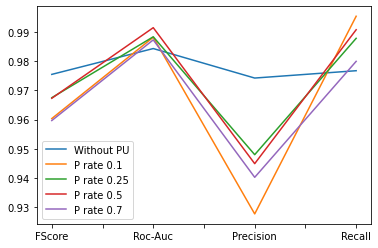

In [49]:
result.plot()

Вообще при использовании алгоритма PU сильно падает precision и Fscore - и чуть поднимаются recall и RocAuc.

Наиболее оптимально для данной задачи брать 50% P, при уменьшении или увеличении P - метрики снижаются.